In [1]:
# Add Libraries
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread

from skimage.exposure import adjust_gamma
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import matplotlib.image as mpimg

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from moviepy.editor import VideoFileClip

%matplotlib inline

Drawing Rectangles on images
The first step is to define a function draw_boxes which will be used later to draw bounding rectangles around identified vehicles in images.

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    draw_img = np.copy(img)
    
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

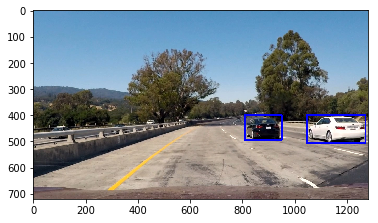

In [3]:
bboxes = [((810,400),(950,495)),((1045,400),(1270,505))]
plt.imshow(draw_boxes(mpimg.imread('test_images/test1.jpg'),bboxes=bboxes));

Histogram of Oriented Gradients
Next, I will define a function get_hog_features which will be used to compute a Histogram of Oriented Gradients for a given image.

In [4]:
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, channel=0, 
                        vis=False, feature_vec=True, color_space='YUV'):
    
    if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'Lab':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    img1 = feature_image[:,:,0]
    img2 = feature_image[:,:,1]
    img3 = feature_image[:,:,2]
    if vis == True:
        features1, hog_image1 = hog(img1, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        features2, hog_image2 = hog(img2, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        features3, hog_image3 = hog(img3, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return hog_image1, hog_image2, hog_image3
    
   
    else:      
        features1 = hog(img1, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=True)
        features2 = hog(img2, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        features3 = hog(img3, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return np.concatenate((features1, features2, features3))

In [5]:
# Load car and non-car image sets
vehicle = glob.glob('vehicles/*/*.png')
not_vehicle = glob.glob('non-vehicles/*/*.png')

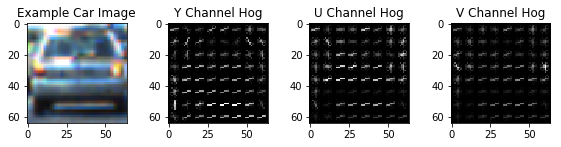

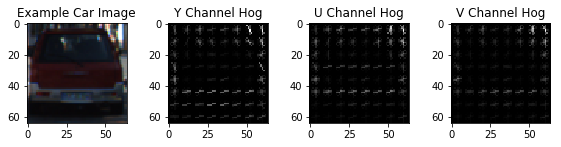

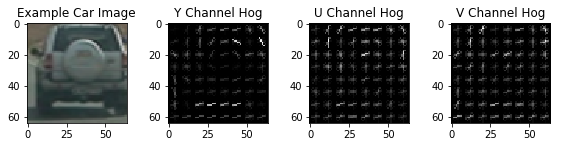

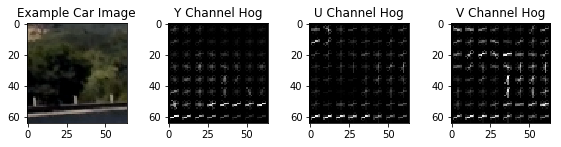

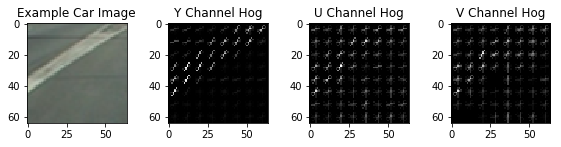

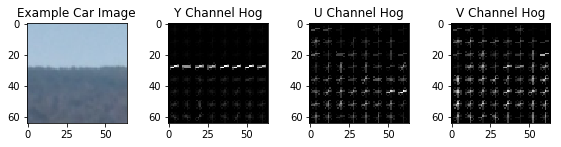

In [6]:
# Generate a random index to look at some images
ind = np.random.randint(0, len(vehicle),size=3)

for i in ind:
    image = imread(vehicle[i])
    hog_image1, hog_image2, hog_image3 = get_hog_features(image, vis=True)
    f, (img1, img2, img3, img4) = plt.subplots(1,4, figsize=(8,3))
    f.tight_layout()
    img1.imshow(image, cmap='gray')
    img1.set_title('Example Car Image')
    img2.imshow(hog_image1, cmap='gray')
    img2.set_title('Y Channel Hog')
    img3.imshow(hog_image2, cmap='gray')
    img3.set_title('U Channel Hog')
    img4.imshow(hog_image3, cmap='gray')
    img4.set_title('V Channel Hog')

for i in ind:
    image = imread(not_vehicle[i])
    hog_image1, hog_image2, hog_image3 = get_hog_features(image, vis=True)
    f, (img1, img2, img3, img4) = plt.subplots(1,4, figsize=(8,3))
    f.tight_layout()
    img1.imshow(image, cmap='gray')
    img1.set_title('Example Car Image')
    img2.imshow(hog_image1, cmap='gray')
    img2.set_title('Y Channel Hog')
    img3.imshow(hog_image2, cmap='gray')
    img3.set_title('U Channel Hog')
    img4.imshow(hog_image3, cmap='gray')
    img4.set_title('V Channel Hog')

Next I will extract the HOG features and build datasets of Car and Non-car images to train a classifier

In [7]:
def extract_features(images, color_space='RGB', orientation=9, pixel_per_cell=8, cell_per_block=2):
   
    features = []
    
    
    for img in images:
        img = imread(img)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'Lab':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img) 

        hog_features = get_hog_features(feature_image, orientation, pixel_per_cell, cell_per_block, vis=False,
                                        feature_vec=True,color_space=color_space)
        features.append(hog_features)
    
    return features

In [8]:
# Build the datasets
car_features = extract_features(vehicle, color_space='YUV')
notcar_features = extract_features(not_vehicle, color_space='YUV')

In [9]:
# Check the number of features for each image
car_features[0].shape

(5292,)

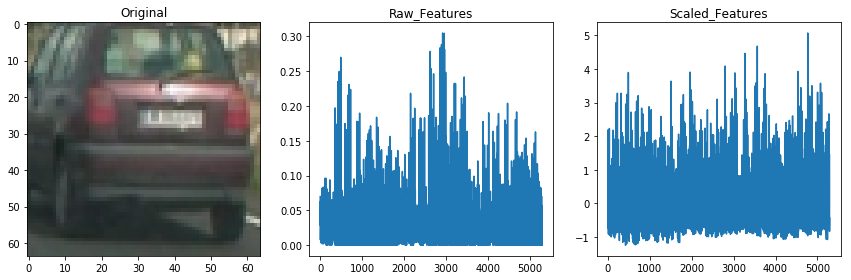

In [12]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    car_ind = np.random.randint(0, len(vehicle))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(vehicle[car_ind]))
    plt.title('Original')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw_Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Scaled_Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')


In [25]:
# Create Labels Array
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 4444
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


 Multi-Layer Perceptron classifier

In [46]:
mlp=MLPClassifier(random_state=54321)
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train MLP...')

# Check the score of the MLP
print('Train Accuracy of MLP = ', mlp.score(X_train, y_train))
print('Test Accuracy of MLP = ', mlp.score(X_test, y_test))

# Check the prediction time for a single sample
t=time.time()
prediction = mlp.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with MLP')

57.40957999229431 Seconds to train MLP...
Train Accuracy of MLP =  1.0
Test Accuracy of MLP =  0.992961711712
0.0033800601959228516 Seconds to predict with MLP


In [47]:
# Visualize a confusion matrix of the predictions from the MLP
pred = mlp.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

,0,1
0,1794,22
1,3,1733


In [39]:
# Save MLP and Scaler
joblib.dump(mlp, 'mlp1.pkl')
joblib.dump(X_scaler, 'scaler1.pkl')

# Load MLP and Scaler
mlp = joblib.load('mlp1.pkl')
X_scaler = joblib.load('scaler1.pkl')

In [40]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [41]:
def annotate(image):
    image = imread(image)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) 
    detected = []
    size = 320
    count = 0
    while size < 720:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 680], 
                            xy_window=(size, size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((feature_image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(current, 9, 8, 2, vis=False,
                                        feature_vec=True,color_space='YUV')
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if mlp.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
            count += 1
        size += 16
    result = np.copy(image)
    mask = np.zeros_like(image)
    
    # Draw all of the boxes on a mask image
    mask = draw_boxes(mask, bboxes=detected, thick=-1)
    
    # Find the contours in the mask
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # Get the coordinates of a bounding rect for each contour
        x,y,w,h = cv2.boundingRect(cnt)
        # Draw the bounding rectangles on the result image
        cv2.rectangle(result, (x, y), (x + w, y + h), (0,255,0), 6)
        M = cv2.moments(cnt)
        c = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
        cv2.circle(result, c, 15, (255, 0, 0), -1)
    f, (image1,image2, image3) = plt.subplots(1,3, figsize=(10,6))
    f.tight_layout()
    image1.axis('off')
    image1.set_title('Image')
    image1.imshow(image)
    image2.axis('off')
    image2.set_title('Car Detections')
    image2.imshow(mask, cmap='hot')
    image3.axis('off')
    image3.set_title('Annotated')
    image3.imshow(result)

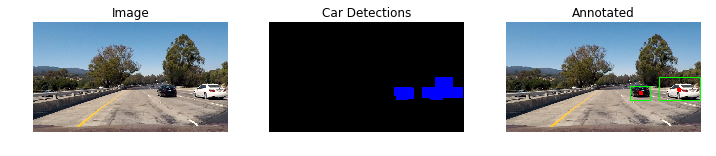

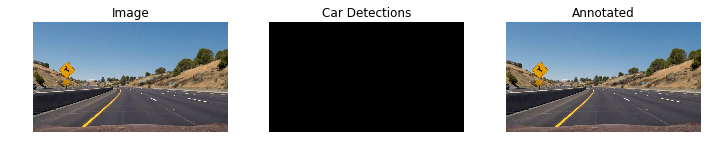

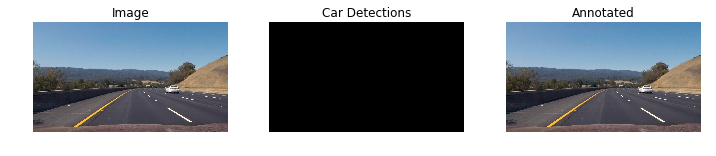

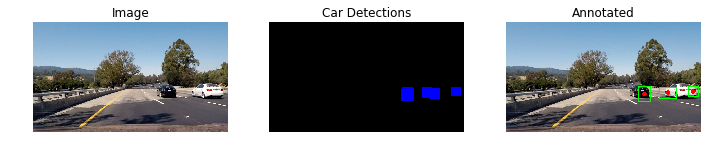

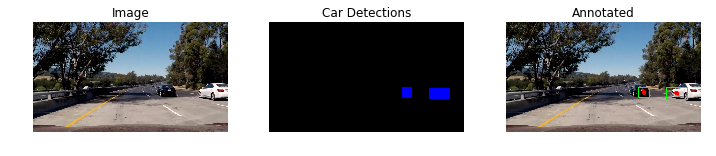

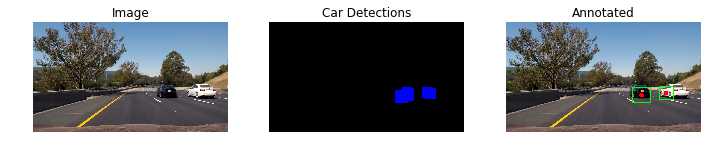

In [42]:
for image in glob.glob('test_images/*.jpg'):
    annotate(image);

In [43]:
class boxes:
    def __init__(self):
        self.count = 0
        self.current = []
        self.minus_1 = []
        self.minus_2 = []
        self.minus_3 = []
        self.minus_4 = []
        self.minus_5 = []
        self.minus_6 = []
        self.minus_7 = []
        self.minus_8 = []

In [44]:
def process_video(image):
    
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    detected = [] 
    size = 320
    count = 0
    while size < 720:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[340, 680], 
                            xy_window=(size, size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((yuv[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(32,32)).astype('uint8')
            hog_features_1 = hog(current[:,:,0], 8, 
                            (4,4), (2,2), visualise=False, feature_vector=True)
            hog_features_2 = hog(current[:,:,1], 8, 
                            (4,4), (2,2), visualise=False, feature_vector=True)
            hog_features_3 = hog(current[:,:,2], 8, 
                            (4,4), (2,2), visualise=False, feature_vector=True)
            features.append(np.concatenate((hog_features_1,
                                           hog_features_2, hog_features_3)))
            scaled_features = X_scaler.transform(features)
            if current.shape[0] > 0:
                if mlp.predict(scaled_features.reshape(1,-1)) == 1 and \
                sgd.decision_function(scaled_features.reshape(1,-1)) > 6000:
                    detected.append(window)
            count += 1
        size += 16
    result = np.copy(image).astype('uint8')
    mask = np.zeros_like(image)
    mask = draw_boxes(mask, bboxes=detected, thick=-1)
    rectangle_list = []
    all_boxes = []
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rectangle_list.append([x,y,x+w,y+h])
    boxes.current = rect_list
    
    if boxes.count > 5:
        all_boxes= boxes.current + boxes.minus_1 + boxes.minus_2 + boxes.minus_3 + boxes.minus_4 +\
                                boxes.minus_5 + boxes.minus_6 +\
                                boxes.minus_7 + boxes.minus_8
        rects,w = cv2.groupRectangles(all_boxes, 6,.1)
        
        for rect in rects:
            cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (0,255,0), 5)
    boxes.minus_8 = boxes.minus_7
    boxes.minus_7 = boxes.minus_6
    boxes.minus_6 = boxes.minus_5
    boxes.minus_5 = boxes.minus_4
    boxes.minus_4 = boxes.minus_3
    boxes.minus_3 = boxes.minus_2
    boxes.minus_2 = boxes.minus_1
    boxes.minus_1 = boxes.current
    boxes.count += 1
    return result

In [49]:
boxes.__init__(boxes)
output = 'result2.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result2.mp4
[MoviePy] Writing video result2.mp4


100%|█████████▉| 1260/1261 [01:19<00:00, 13.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result2.mp4 

CPU times: user 3.93 s, sys: 4.98 s, total: 8.91 s
Wall time: 1min 21s


ValueError: operands could not be broadcast together with shapes (1,4704) (5292,) (1,4704) 